In [67]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import rtree
import re
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
%matplotlib inline

In [2]:
dockless_agg_census_chopped = pd.read_csv('../dockless_agg_census_chopped.csv',infer_datetime_format=True,\
                       parse_dates=['start_time','end_time','date'],encoding='ascii')

In [3]:
dockless_agg_census_chopped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304470 entries, 0 to 2304469
Data columns (total 8 columns):
id               object
device_id        object
trip_duration    float64
trip_distance    float64
start_time       datetime64[ns]
end_time         datetime64[ns]
date             datetime64[ns]
TRACTCE10        int64
dtypes: datetime64[ns](3), float64(2), int64(1), object(2)
memory usage: 140.7+ MB


In [4]:
groupby_ct = dockless_agg_census_chopped.groupby('TRACTCE10',as_index=False).count()[['TRACTCE10','id']].sort_values('id')

### Baseline model which detects events based on time series forecasting of the number of trips per day

In [5]:
groupby_date = dockless_agg_census_chopped.groupby('date').count()[['id']].sort_index()

In [6]:
groupby_date = groupby_date[27:]

In [7]:
groupby_date.shape

(266, 1)

In [8]:
groupby_date.rename({'id':'no_of_trips'},axis=1,inplace=True)

In [9]:
train, test = groupby_date[0:-90], groupby_date[-90:]
train_log, test_log = np.log10(train), np.log10(test)
my_order = (1, 1, 1)
my_seasonal_order = (0, 1, 1, 7)

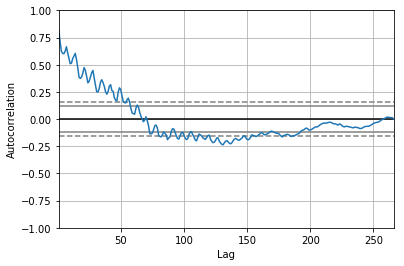

In [10]:
autocorrelation_plot(groupby_date)

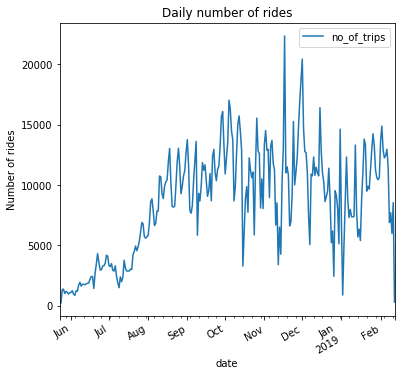

In [11]:
fig,ax = plt.subplots()
groupby_date.plot.line(y='no_of_trips',figsize=(6,6),ax=ax)
plt.ylabel('Number of rides')
plt.title('Daily number of rides')
ax.xaxis_date()     
fig.autofmt_xdate()

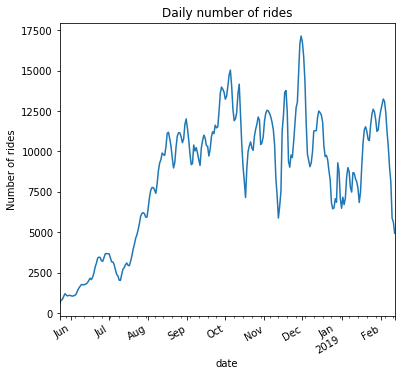

In [12]:
fig,ax = plt.subplots()
groupby_date.no_of_trips.rolling(5,center=True,min_periods=1,axis=0).mean().plot.line(y='no_of_trips',figsize=(6,6),ax=ax)
plt.ylabel('Number of rides')
plt.title('Daily number of rides')
ax.xaxis_date()     
fig.autofmt_xdate()

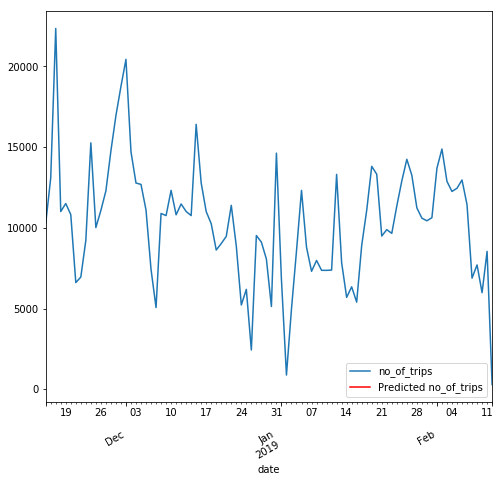

CPU times: user 1min 23s, sys: 260 ms, total: 1min 23s
Wall time: 32.4 s


In [13]:
%%time
history = [x for x in train_log.values]
predictions = []
predict_log= []
for key,value in test_log.iterrows():
    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
    model_fit = model.fit(disp=0,maxiter=200,method='powell')
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log.loc[key]
    history.append(obs)
   # print('predicted=%f, expected=%f' % (output[0], obs))
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)
# plot
fig,ax = plt.subplots(figsize=(8, 8))
# figsize=(12, 7)
# plt.figure(figsize=figsize)
test.plot(label='Actuals',ax=ax)
ax.plot(test_log.index,predictions, color='red',label='Predicted no_of_trips')
plt.legend(loc='lower right')
ax.xaxis_date()     
fig.autofmt_xdate()
plt.show()

In [14]:
predicted_df=pd.DataFrame()
predicted_df['date']=groupby_date.index[-90:]
predicted_df['actuals']= test.values
predicted_df['predicted']=predictions
predicted_df.reset_index(inplace=True)
del predicted_df['index']
predicted_df.head()

,date,actuals,predicted
0,2018-11-15,10276,6048.597673
1,2018-11-16,13091,9041.954888
2,2018-11-17,22357,9697.866151
3,2018-11-18,11016,15213.854980
4,2018-11-19,11513,6872.824403


In [15]:
import numpy as np
def detect_classify_anomalies(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = (df['error'] / df['actuals']) * 100
    df['meanval'] = df['error'].mean()#rolling(window=window,center=True,min_periods=1).mean()
    df['deviation'] = df['error'].std()#rolling(window=window,center=True,min_periods=1).std()
    df['anomaly'] = df.apply(lambda x: 1 if(x['error']>=x['meanval']+2*x['deviation']\
                                            or x['error']<=x['meanval']-2*x['deviation'] ) else 0,axis=1)
    df = df.sort_values(by='date')
    df.date = pd.to_datetime(df['date'].astype(str), format="%Y-%m-%d")
    return df

In [16]:
classify_df=detect_classify_anomalies(predicted_df,5)
classify_df.reset_index(inplace=True,drop=True)

In [17]:
classify_df[classify_df['anomaly']==1]

,date,actuals,predicted,error,percentage_change,meanval,deviation,anomaly
2,2018-11-17,22357,9697.866151,12659.133849,56.622686,236.002677,3397.30305,1
21,2018-12-06,7434,14710.750319,-7276.750319,-97.884723,236.002677,3397.30305,1
46,2018-12-31,14633,4670.124371,9962.875629,68.084983,236.002677,3397.30305,1
85,2019-02-08,6891,14008.051202,-7117.051202,-103.280383,236.002677,3397.30305,1
89,2019-02-12,303,8709.959809,-8406.959809,-2774.574194,236.002677,3397.30305,1


In [18]:
classify_df.loc[classify_df['anomaly']==1].actuals

2     22357
21     7434
46    14633
85     6891
89      303
Name: actuals, dtype: int64

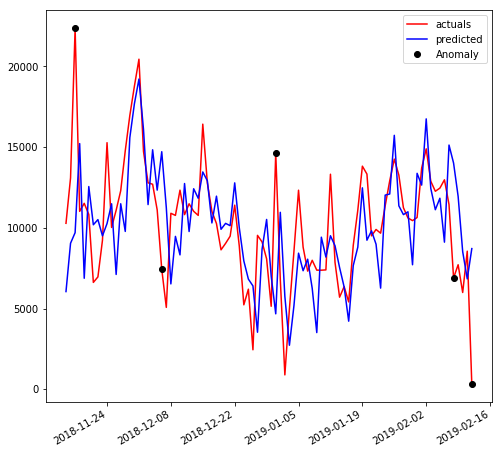

In [65]:
fig,ax = plt.subplots(figsize=(8, 8))
ax.plot(classify_df.date,classify_df.actuals,'r')
ax.plot(classify_df.date,classify_df.predicted,'b')
ax.plot(classify_df.loc[classify_df['anomaly']==1].date,classify_df.loc[classify_df['anomaly']==1].actuals,\
        'o',color='black',label='Anomaly')
ax.xaxis_date()     
fig.autofmt_xdate()
plt.legend()

### Isolation Forest

In [29]:
dockless_agg_census_chopped.pivot_table(index='date',columns='TRACTCE10',values='id',aggfunc='count',fill_value=0)[50:56]

TRACTCE10,101,102,203,204,205,206,302,304,305,306,307,401,402,500,601,603,604,700,801,802,803,804,901,902,1000,...,2427,2428,2429,2430,2431,2432,2433,2435,2500,10901,20311,20316,20318,20403,20404,20405,20406,20408,20409,20410,20411,20508,20509,20510,980000
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-15,0,0,0,1,0,0,0,0,0,0,0,19,1,4,58,36,37,92,0,0,1,7,26,112,21,...,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-06-16,0,0,0,0,0,0,0,0,1,1,0,6,3,0,28,31,35,91,0,1,1,10,21,181,61,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-06-17,1,0,0,1,1,0,0,0,0,0,1,7,5,3,33,12,9,106,0,0,3,10,34,185,36,...,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-06-18,0,0,0,2,0,0,2,0,0,2,0,25,3,5,142,67,64,74,1,0,0,4,23,101,15,...,0,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-06-19,0,0,0,0,0,0,1,0,0,0,0,6,0,2,165,74,42,28,0,0,2,6,2,82,19,...,0,0,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-06-20,0,0,0,3,0,0,2,0,0,2,0,33,3,13,293,129,113,87,0,1,0,9,23,106,8,...,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
dockless_agg_census_chopped.head()

,id,device_id,trip_duration,trip_distance,start_time,end_time,date,TRACTCE10
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,358.0,915.0,2018-06-29 17:30:00,2018-06-29 17:30:00,2018-06-29,1303
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,226.0,839.0,2018-11-30 11:00:00,2018-11-30 11:00:00,2018-11-30,604
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,324.0,1206.0,2018-10-02 15:15:00,2018-10-02 15:30:00,2018-10-02,601
3,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,408.0,1144.0,2018-09-28 11:45:00,2018-09-28 11:45:00,2018-09-28,2304
4,00002f2a-0bcd-4446-bb39-df9fd62be813,d7f470bf-8f4f-4a07-bed7-1f091014920f,1094.0,2631.0,2018-07-22 16:30:00,2018-07-22 16:45:00,2018-07-22,1305


In [133]:
trip_info = dockless_agg_census_chopped.groupby('date',as_index=False).mean()[['date','trip_duration','trip_distance']]

In [134]:
trip_count = dockless_agg_census_chopped.groupby('date',as_index=False).count()[['date','id']]
trip_count.rename({'id':'no_of_trips'},axis=1,inplace=True)

In [135]:
trip_info = trip_info.merge(trip_count,on='date')

In [136]:
trip_info = trip_info[27:]

#### The contamination(% of total which are outliers) parameter of the Isolation Forest needs to be played around with in order to see if the predicted anomalies make sense. So, we apply PCA on the 3 standardized features and then, we make a scatter plot of the 2 most prominent features obtained using PCA. There is a obvious trade-off here between the number of False Positives and False Negatives. In our case, it would be better to identify some normal days as anomalous rather than missing anomalous days and classifying them as normal.

#### Contamination = 0.08

In [185]:
# Standardize the features
data = pd.DataFrame(StandardScaler().fit_transform(trip_info.iloc[:,1:4]))
# Train the model(contamination needs to be played with to get the ideal value)
model =  IsolationForest(contamination=0.04,behaviour='new',random_state=2019)
model.fit(data) 
trip_info['anomaly'] = pd.Series(model.predict(data))
outlier_index = list(trip_info[trip_info['anomaly']==-1].index)
print(trip_info.anomaly.value_counts())

/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


 1.0    232
-1.0      7
Name: anomaly, dtype: int64


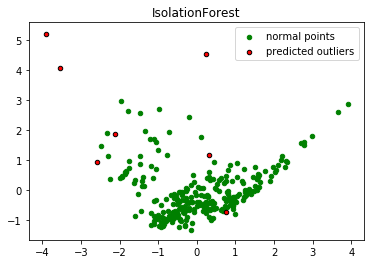

In [186]:
pca = PCA(2)
pca.fit(data)
res=pd.DataFrame(pca.transform(data))
Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res.iloc[~res.index.isin(outlier_index),0], res.iloc[~res.index.isin(outlier_index),1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',s=20,  edgecolor="black",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [193]:
# Standardize the features
data = pd.DataFrame(StandardScaler().fit_transform(trip_info.iloc[:,1:4]))
# Train the model(contamination needs to be played with to get the ideal value)
model =  IsolationForest(contamination=0.08,behaviour='new',random_state=2019)
model.fit(data) 
trip_info['anomaly'] = pd.Series(model.predict(data))
outlier_index = list(trip_info[trip_info['anomaly']==-1].index)
print(trip_info.anomaly.value_counts())

/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


 1.0    224
-1.0     15
Name: anomaly, dtype: int64


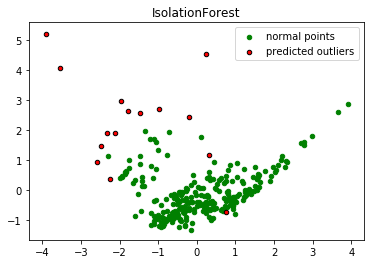

In [194]:
pca = PCA(2)
pca.fit(data)
res=pd.DataFrame(pca.transform(data))
Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res.iloc[~res.index.isin(outlier_index),0], res.iloc[~res.index.isin(outlier_index),1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',s=20,  edgecolor="black",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [195]:
res.head()

,0,1
0,1.890993,0.289676
1,2.289749,0.755992
2,2.054241,0.676506
3,2.971649,1.794477
4,3.922457,2.882487


In [196]:
data.head()

,0,1,2
0,0.833723,-0.371666,-1.828534
1,1.544567,-0.368795,-1.849858
2,1.429563,-0.369707,-1.598008
3,3.135204,-0.362926,-1.591948
4,4.792748,-0.355969,-1.672306


In [191]:
# Standardize the features
data = pd.DataFrame(StandardScaler().fit_transform(trip_info.iloc[:,1:4]))
# Train the model(contamination needs to be played with to get the ideal value)
model =  IsolationForest(contamination=0.40,behaviour='new',random_state=2019)
model.fit(data) 
trip_info['anomaly'] = pd.Series(model.predict(data))
outlier_index = list(trip_info[trip_info['anomaly']==-1].index)
print(trip_info.anomaly.value_counts())

/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


 1.0    152
-1.0     87
Name: anomaly, dtype: int64


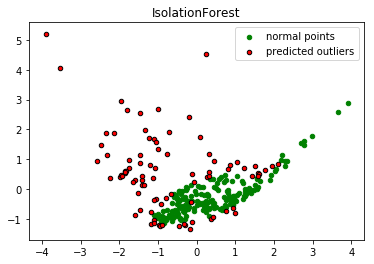

In [192]:
pca = PCA(2)
pca.fit(data)
res=pd.DataFrame(pca.transform(data))
Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res.iloc[~res.index.isin(outlier_index),0], res.iloc[~res.index.isin(outlier_index),1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',s=20,  edgecolor="black",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [183]:
# Standardize the features
data = pd.DataFrame(StandardScaler().fit_transform(trip_info.iloc[:,1:4]))
# Train the model(contamination needs to be played with to get the ideal value)
model =  IsolationForest(contamination=0.15,behaviour='new',random_state=2019)
model.fit(data) 
trip_info['anomaly'] = pd.Series(model.predict(data))
outlier_index = list(trip_info[trip_info['anomaly']==-1].index)
print(trip_info.anomaly.value_counts())

/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/nishi/lib/python2.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


 1.0    207
-1.0     32
Name: anomaly, dtype: int64


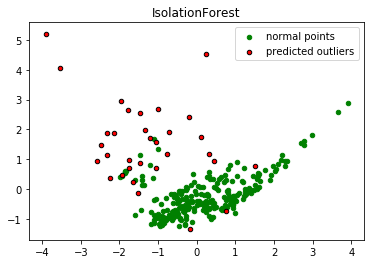

In [184]:
pca = PCA(2)
pca.fit(data)
res=pd.DataFrame(pca.transform(data))
Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res.iloc[~res.index.isin(outlier_index),0], res.iloc[~res.index.isin(outlier_index),1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='red',s=20,  edgecolor="black",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

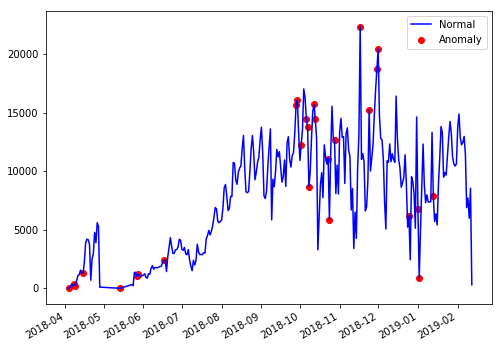

In [96]:
# visualization
fig, ax = plt.subplots(figsize=(8,6))

anomaly = trip_info.loc[trip_info['anomaly'] == -1, :]

ax.plot(trip_info['date'], trip_info['no_of_trips'], color='blue', label = 'Normal')
ax.scatter(anomaly['date'],anomaly['no_of_trips'], color='red', label = 'Anomaly')
plt.legend()
ax.xaxis_date()     
fig.autofmt_xdate()

plt.show();

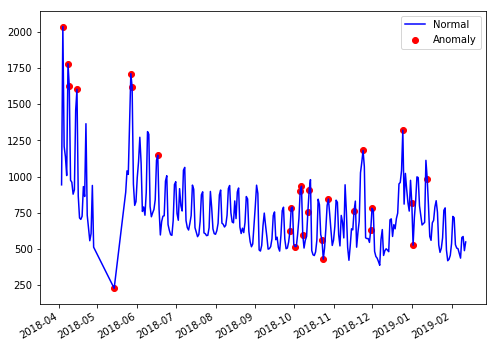

In [97]:
fig, ax = plt.subplots(figsize=(8,6))

anomaly = trip_info.loc[trip_info['anomaly'] == -1, :]

ax.plot(trip_info['date'], trip_info['trip_duration'], color='blue', label = 'Normal')
ax.scatter(anomaly['date'],anomaly['trip_duration'], color='red', label = 'Anomaly')
plt.legend()
ax.xaxis_date()     
fig.autofmt_xdate()

plt.show();

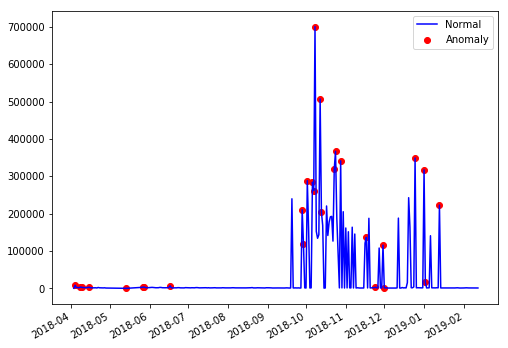

In [98]:
fig, ax = plt.subplots(figsize=(8,6))

anomaly = trip_info.loc[trip_info['anomaly'] == -1, :]

ax.plot(trip_info['date'], trip_info['trip_distance'], color='blue', label = 'Normal')
ax.scatter(anomaly['date'],anomaly['trip_distance'], color='red', label = 'Anomaly')
plt.legend()
ax.xaxis_date()     
fig.autofmt_xdate()

plt.show();